# Decison Tree - QRT ENS Data Challenge


## Libraries

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


## Loading data


In [4]:
#load dataset. In this case the final dataset was used.

X_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('x_test.csv')

In [ ]:
X_train.head()

,ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,...,DE_WIND_EXCESS,FR_WIND_EXCESS,FR_OVERCON,DE_NUCLEAR_CLUSTER,DE_NUCLEAR_0,DE_NUCLEAR_1,DE_NUCLEAR_2,DE_NUCLEAR_3,DE_NUCLEAR_4,DE_NUCLEAR_5
0,1054,0.210099,-0.427458,-0.074847,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,...,-0.424541,-1.081876,-2.063908,3,0.0,0.0,0.0,1.0,0.0,0.0
1,2049,-0.022399,-1.003452,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,...,-0.802641,-0.491355,0.609125,2,0.0,0.0,1.0,0.0,0.0,0.0
2,1924,1.395035,1.978665,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,...,-0.289006,-0.357727,-1.384961,2,0.0,0.0,1.0,0.0,0.0,0.0
3,297,-0.983324,-0.849198,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,...,-0.173801,-0.380780,-0.250896,1,0.0,1.0,0.0,0.0,0.0,0.0
4,1101,0.143807,-0.617038,-0.036917,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,...,-0.026802,-0.213282,-3.943384,1,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Decision Tree and train score

In [10]:
# Create a decision tree regressor
y_train_clean = y_train['TARGET']

dt = DecisionTreeRegressor(random_state=42)

# Fit the bagging regressor on the data
dt.fit(X_train, y_train_clean)

# Predict on the training set
output_train_dt = dt.predict(X_train)



In [8]:
def metric_train(output):
    # calculate MSE
    mse = mean_squared_error(y_train_clean, output)
    # calculate MAE
    mae = mean_absolute_error(y_train_clean, output)
    # calculate Spearman correlation
    print('Mean Squared Error (MSE) for the train set using decision tree: {:.5f}'.format(mse))
    print('Mean Absolute Error (MAE) for the train set using decision tree:{:.5f}'.format(mae))
    print('Spearman correlation for the train set using decision tree: {:.1f}%'.format(100 * spearmanr(output, y_train_clean).correlation))
    return spearmanr(output, y_train_clean).correlation

In [11]:
# Calculate and print the Spearman correlation for the train set
sprmanr = metric_train(output_train_dt)

Mean Squared Error (MSE) for the train set using decision tree: 0.00000
Mean Absolute Error (MAE) for the train set using decision tree:0.00000
Spearman correlation for the train set using decision tree: 100.0%


The Spearman correlation obtained with our model on the train data set is 100%. MSE is 0 and MAE is 0.

## Hyperparameter Tuning

In [12]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict

In [13]:
# Define the custom scoring function using Spearman correlation
def custom_spearman_scorer(estimator, X, y):
    predictions = estimator.predict(X)
    spearman_corr, _ = spearmanr(predictions, y)
    return spearman_corr

In [14]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 12],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error']
}

# Update GridSearchCV object with the custom scoring function
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=custom_spearman_scorer)

# Fit the GridSearchCV object on the data
grid_search.fit(X_train, y_train_clean)

# Get the best estimator from the grid search
best_dt = grid_search.best_estimator_

# Predict on the training set using the best model
output_train_best_bagging = best_dt.predict(X_train)

# Print the best parameters and the Spearman correlation for the train set
print('Best Parameters:', grid_search.best_params_)
print('Spearman correlation for the train set using the best model: {:.1f}%'.format(100 * metric_train(output_train_best_bagging)))

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 5}
Mean Squared Error (MSE) for the train set using decision tree: 1.01238
Mean Absolute Error (MAE) for the train set using decision tree:0.51095
Spearman correlation for the train set using decision tree: 36.9%
Spearman correlation for the train set using the best model: 36.9%


After tuning, our best set of parameters is 'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 5
Spearman correlation for the train set using the best model: 36.9%.
MSE is 1.01238 and MAE us 0.51095


In [ ]:
y_test_submission = X_test[['ID']].copy()
y_test_submission['TARGET'] = best_dt.predict(X_test)

y_test_submission.to_csv('DecisionTree_tune_final_data.csv', index=False)

After submitting the csv file on Challenge, we obtained a public score around 21.86%. The performance of Decision Tree using our modified data is significantly better than the unmodified data. Note that the result before feature engineering for Decision Tree is 13.91%

## Observe Feature Importance

For this data we use permutation importance instead of feature_importance_. This is because feature_importance_ has a tendency to inflate the importance of continuous features.

In [20]:
from sklearn.inspection import permutation_importance

# Check the shape of y_train
print(y_train.shape)

# Select target column
y_train_single_column = y_train['TARGET']

# Calculate permutation importances
result = permutation_importance(best_dt, X_train, y_train_single_column, n_repeats=30, random_state=42)

# Display feature importances
for feature, importance in zip(X_train.columns, result.importances_mean):
    print(f'{feature}: {importance}')


(1494, 2)
ID: 0.042067416721902104
DE_CONSUMPTION: 0.0
FR_CONSUMPTION: 0.0
DE_NET_IMPORT: 0.006393404624043934
FR_NET_IMPORT: 0.0
DE_GAS: 0.0
FR_GAS: 0.0
DE_COAL: 0.0
FR_COAL: 0.0029200880150112426
DE_HYDRO: 0.001790256077054501
FR_HYDRO: 0.0
DE_NUCLEAR: 0.0
FR_NUCLEAR: 0.0021233584269998327
DE_SOLAR: 0.012245453896383991
FR_SOLAR: 0.0
DE_WINDPOW: 0.03695890680331721
FR_WINDPOW: 0.0
DE_LIGNITE: 0.0009779280897376415
DE_RESIDUAL_LOAD: 0.0863626637467827
FR_RESIDUAL_LOAD: 0.0041536947290566895
DE_RAIN: 0.0
FR_RAIN: 0.0
DE_WIND_SQCB: 0.0
FR_WIND_SQCB: 0.0
DE_TEMP: 0.0
FR_TEMP: 0.0
GAS_RET: 0.011035018687288551
COAL_RET: 0.0026462717701686215
CARBON_RET: 0.006574685411703214
DE_WIND_EXCESS: 0.0
FR_WIND_EXCESS: 0.0
FR_OVERCON: 0.0
DE_NUCLEAR_CLUSTER: 0.0
DE_NUCLEAR_0: 0.0
DE_NUCLEAR_1: 0.0
DE_NUCLEAR_2: 0.0
DE_NUCLEAR_3: 0.0
DE_NUCLEAR_4: 0.0
DE_NUCLEAR_5: 0.0


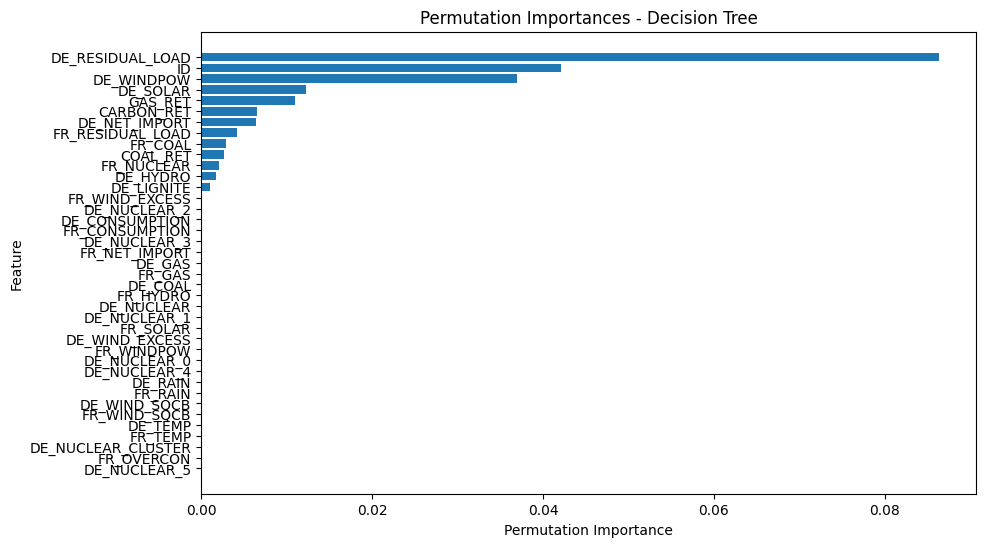

In [26]:
import matplotlib.pyplot as plt

# Sort features based on importance
sorted_idx = result.importances_mean.argsort()
features_sorted = X_train.columns[sorted_idx]
importance_sorted = result.importances_mean[sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(features_sorted)), importance_sorted, align="center")
plt.yticks(range(len(features_sorted)), features_sorted)
plt.ylabel("Feature")
plt.xlabel("Permutation Importance")
plt.title("Permutation Importances - Decision Tree")
plt.show()



